In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install -r requirements.txt

In [3]:
import os
import numpy as np
import tensorflow as tf
import nibabel as nib
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize

import argparse
import logging
import os
import random
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from utils import DiceLoss
from torchvision import transforms
from utils import test_single_volume

import zipfile
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [4]:
from config import get_config

args = argparse.ArgumentParser()
args.cfg = "configs/swin_tiny_patch4_window7_224_lite.yaml"
args.batch_size = 12
args.cache_mode = 'no'

config = get_config(args)

=> merge config from configs/swin_tiny_patch4_window7_224_lite.yaml


In [5]:
# Preprocess data for swin unet
# It expects 2d slices, not 3d volume

def process_volume(volume):
    # Clip and normalize the volume
    clipped_volume = np.clip(volume, -125, 275)
    min_val, max_val = clipped_volume.min(), clipped_volume.max()
    normalized_volume = (clipped_volume - min_val) / (max_val - min_val)
    return normalized_volume

def extract_and_process_volume(zip_path, temp_dir):
    # Extract .nii.gz file from zip archive
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    nii_path = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.endswith('.nii.gz')][0]
    # Load and process volume
    volume = nib.load(nii_path).get_fdata()
    processed_volume = process_volume(volume)
    # Cleanup extracted files
    os.remove(nii_path)
    return processed_volume

def crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty+cropy, startx:startx+cropx, :]

def process_and_save_slices(volume, label_volume, output_dir, base_filename):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Extract slices and save them
    for i in range(volume.shape[2]):  # Assuming the volume shape is (256, 256, 128)
        image_slice = volume[:, :, i]
        label_slice = label_volume[:, :, i]
        
        # Crop slices to 224
        image_slice = crop_center(image_slice, 224, 224)
        label_slice = crop_center(label_slice, 224, 224)
        
        # Reshape slices to (1, 224, 224)
        image_slice = np.transpose(image_slice, (2, 0, 1))
        label_slice = np.transpose(label_slice, (2, 0, 1))
        
        # Save as compressed .npz file
        slice_filename = os.path.join(output_dir, f'{base_filename}_slice_{i}.npz')
        np.savez_compressed(slice_filename, image=image_slice, label=label_slice)


image_dir = 'datasets/ULS23_Radboudumc_Bone/images'
label_dir = 'datasets/ULS23_Radboudumc_Bone/labels'
output_dir = 'datasets/preprocessed'
temp_dir = 'temp_labels'


if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Loop through the image files
for image_filename in tqdm(os.listdir(image_dir)):
    if image_filename.endswith('.nii.gz'):
        base_filename = image_filename[:-7]  # Remove extension to match with label file
        image_path = os.path.join(image_dir, image_filename)
        label_zip_path = os.path.join(label_dir, base_filename + '.nii.gz.zip')
        
        # Process image volume
        image_volume = nib.load(image_path).get_fdata()
        image_slices = process_volume(image_volume)
        
        # Process label volume
        label_slices = extract_and_process_volume(label_zip_path, temp_dir)
        
        # Save slices
        process_and_save_slices(image_slices, label_slices, output_dir, base_filename)

# Cleanup temporary directory
os.rmdir(temp_dir)

print("Preprocessing done.")

100%|████████████████████████████████████████████████████████████████████████████| 744/744 [15:22<00:00,  1.24s/it]

Preprocessing done.


In [21]:
class NiftiDataset(Dataset):
    def __init__(self, slices_dir, transform=None):
        self.slices_dir = slices_dir
        self.transform = transform
        self.filenames = [f for f in os.listdir(slices_dir) if f.endswith('.npz')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        slice_path = os.path.join(self.slices_dir, self.filenames[idx])
        
        # Load image
        data = np.load(slice_path)
        image, label = data['image'], data['label']
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        sample['case_name'] = self.filenames[idx].strip('\n')
        return sample

In [22]:
slices_dir = 'datasets/preprocessed'

db_train = NiftiDataset(slices_dir)
print("The length of train set is: {}".format(len(db_train)))
trainloader  = DataLoader(db_train, batch_size=args.batch_size, shuffle=True)

The length of train set is: 5705


In [23]:
from networks.vision_transformer import SwinUnet

model = SwinUnet(config, img_size=224, num_classes=2).cuda()
model.load_from(config)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2
---final upsample expand_first---
pretrained_path:./pretrained_ckpt/swin_tiny_patch4_window7_224.pth
---start load pretrained modle of swin encoder---


In [24]:
model.train()

SwinUnet(
  (swin_unet): SwinTransformerSys(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=96, input_resolution=(56, 56), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=96, window_size=(7, 7), num_heads=3
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
      

In [25]:
ce_loss = CrossEntropyLoss()
dice_loss = DiceLoss(2)
base_lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)

In [26]:
iter_num = 0
max_epoch = 500
max_iterations = max_epoch * len(trainloader)

In [27]:
best_performance = 0.0
snapshot_path = 'snapshots'

In [28]:
overall_start = timer()
history = []

iterator = tqdm(range(max_epoch), ncols=100)
for epoch_num in iterator:
    start = timer()
    history_ce = 0.0
    history_dice = 0.0
    history_loss = 0.0
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
        image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        
        outputs = model(image_batch)
        
        loss_ce = ce_loss(outputs, label_batch.squeeze(1).long())
        loss_dice = dice_loss(outputs, label_batch.squeeze(1), softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_

        history_ce += loss_ce.item()
        history_dice += loss_dice.item()
        history_loss += loss.item()
        iter_num += 1
        # Track training progress
        print(
            f'Epoch: {epoch_num}\t{100 * (i_batch + 1) / len(trainloader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')
        
    history_ce /= len(trainloader)
    history_dice /= len(trainloader)
    history_loss /= len(trainloader)
    history.append([history_ce, history_dice, history_loss])
    
    save_history_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '_history.npz')
    np.savez_compressed(save_history_path, history=history)
    save_model_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
    torch.save(model.state_dict(), save_model_path)
    print("Saved model to {}".format(save_model_path))
iterator.close()

total_time = timer() - overall_start
print(f'{total_time:.2f} total seconds elapsed. {total_time / (max_epoch+1):.2f} seconds per epoch.')

  0%|                                                                       | 0/500 [00:00<?, ?it/s]

  0%|                                                           | 1/500 [02:47<23:15:46, 167.83s/it]

  0%|▏                                                          | 2/500 [05:33<23:04:46, 166.84s/it]

  1%|▎                                                          | 3/500 [08:20<23:01:12, 166.74s/it]

  1%|▍                                                          | 4/500 [11:21<23:44:04, 172.27s/it]

  1%|▌                                                          | 5/500 [14:17<23:52:18, 173.61s/it]

  1%|▋                                                          | 6/500 [17:12<23:54:12, 174.19s/it]

  1%|▊                                                          | 7/500 [20:08<23:56:57, 174.88s/it]

  2%|▉                                                          | 8/500 [23:08<24:05:36, 176.29s/it]

  2%|█                                                          | 9/500 [26:00<23:53:25, 175.16s/it]

  2%|█▏                                                        | 10/500 [28:54<23:47:31, 174.80s/it]

  2%|█▎                                                        | 11/500 [31:48<23:42:42, 174.57s/it]

  2%|█▍                                                        | 12/500 [34:44<23:40:59, 174.71s/it]

  3%|█▌                                                        | 13/500 [37:41<23:44:06, 175.46s/it]

  3%|█▌                                                        | 14/500 [40:36<23:41:26, 175.49s/it]

  3%|█▋                                                        | 15/500 [43:32<23:38:42, 175.51s/it]

  3%|█▋                                                        | 15/500 [43:51<23:38:07, 175.44s/it]


KeyboardInterrupt: 

[[0.23468151 5.91092386 3.64042706]
 [0.2217117  5.87669821 3.61470375]
 [0.226814   5.87760525 3.6172889 ]
 [0.21590531 5.69668952 3.50437597]
 [0.1531178  4.97912012 3.04871931]
 [0.13365945 4.75537933 2.9066915 ]
 [0.0992101  4.35192335 2.65083816]
 [0.10269802 4.28780727 2.61376368]
 [0.09335303 4.17197641 2.54052715]
 [0.08492277 4.09940214 2.49361049]
 [0.08220279 4.03483093 2.45377978]
 [0.08221185 3.97925924 2.42044038]
 [0.0815304  4.12073748 2.50505475]
 [0.07374155 3.9157478  2.37894539]
 [0.07117305 3.83088651 2.32700123]]


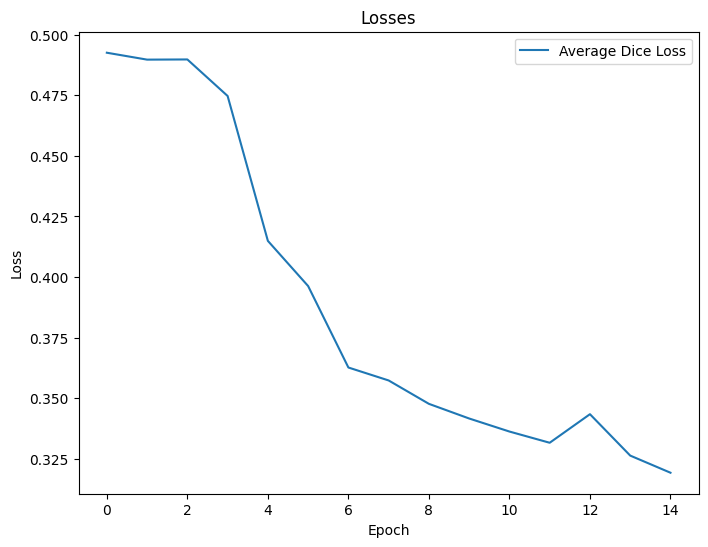

In [31]:
history_path = os.path.join(snapshot_path, 'epoch_500_history.npz')
history = np.load(history_path)['history']
print(history)

history_np = np.array(history)

history_np /= 12

plt.figure(figsize=(8, 6))
# plt.plot(history_np[:, 0], label="Average Cross Entropy Loss")
plt.plot(history_np[:, 1], label="Average Dice Loss")
# plt.plot(history_np[:, 2], label="Average Cross Entropy Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.show()

In [ ]:
model = SwinUnet(config, img_size=224, num_classes=2).cuda()
model.load_from(config)
model.load_state_dict(torch.load('snapshots/epoch_0.pth'))